# **Project 2 – HIV New Diagnoses and Neighborhood Income in New York City**

## **Research Question**

This project examines the relationship between **HIV new diagnosis rates** and **median household income** across New York City’s **UHF (United Hospital Fund) neighborhoods**. Using HIV surveillance data from **NYC Open Data** and income estimates from the **ACS 5-year Census**, the analysis merges the two datasets at the neighborhood level to evaluate how HIV burden varies with local income levels.

The key objective is to assess whether **lower-income neighborhoods** tend to experience **higher rates of new HIV diagnoses**, and to evaluate the stability of this pattern across multiple years.

This study is designed as an **exploratory correlational analysis**, rather than a causal investigation. Because HIV outcomes are shaped by **structural and place-based inequalities**—including access to healthcare, demographic composition, and long-standing socioeconomic disparities—income alone is unlikely to fully explain geographic differences. The analysis therefore focuses on describing broad spatial and temporal patterns in HIV burden relative to neighborhood income.



## **Loading and Cleaning Income Data (ACS 5-Year ZIP Code Estimates)**

This section loads the 2018–2022 ACS 5-year B19013 income tables from the U.S. Census Bureau, extracts ZIP-code–level median household income, standardizes ZIP codes, and converts income values to numeric format. The cleaned ZIP-level income data will later be linked to UHF neighborhoods using a ZIP–UHF crosswalk.



In [3]:
import pandas as pd

income_files = {
    2018: "ACSDT5Y2018.B19013-Data.csv",
    2019: "ACSDT5Y2019.B19013-Data.csv",
    2020: "ACSDT5Y2020.B19013-Data.csv",
    2021: "ACSDT5Y2021.B19013-Data.csv",
    2022: "ACSDT5Y2022.B19013-Data.csv",
}

dfs = []

for year, file in income_files.items():
    df = pd.read_csv(file)
    df["year"] = year
    dfs.append(df)

income_all = pd.concat(dfs, ignore_index=True)

income_all = income_all.rename(columns={
    "GEO_ID": "geography",
    "NAME": "name",
    "B19013_001E": "median_income"
})

income_all = income_all[["name", "median_income", "year"]]

income_all["zipcode"] = income_all["name"].str.replace(r"ZCTA5\s+", "", regex=True)
income_all["zipcode"] = income_all["zipcode"].astype(str)
income_all["median_income"] = pd.to_numeric(income_all["median_income"], errors="coerce")

income_all.head()



,name,median_income,year,zipcode
0,Geographic Area Name,NaN,2018,Geographic Area Name
1,ZCTA5 00601,13092.0,2018,00601
2,ZCTA5 00602,16358.0,2018,00602
3,ZCTA5 00603,16603.0,2018,00603
4,ZCTA5 00606,12832.0,2018,00606


## **ZIP–UHF Crosswalk and Neighborhood-Level Income Aggregation**

This section merges ZIP-level ACS income data with a ZIP–UHF crosswalk and computes neighborhood-level average median income for each year.


In [8]:
zip_uhf = pd.DataFrame({
    "zipcode": [
        "10463", "10471", 
        "10466", "10469", "10470", "10475", 
        "10458", "10467", "10468", 
        "10461", "10462", "10464", "10465", "10472", "10473", 
        "10453", "10457", "10460",
        "10451", "10452", "10456", 
        "10454", "10455", "10459", "10474", 
        "11211", "11222", 
        "11201", "11205", "11215", "11217", "11231", 
        "11213", "11212", "11216", "11233", "11238", 
        "11207", "11208", 
        "11220", "11232", 
        "11204", "11218", "11219", "11230", 
        "11203", "11210", "11225", "11226", 
        "11234", "11236", "11239", 
        "11209", "11214", "11228", 
        "11223", "11224", "11229", "11235", 
        "11206", "11221", "11237",
        "10031", "10032", "10033", "10034", "10040", 
        "10026", "10027", "10030", "10037", "10039", 
        "10029", "10035",
        "10023", "10024", "10025",
        "10021", "10028", "10044", "10128",
        "10001", "10011", "10118", "10019", "10020", "10036",
        "10010", "10016", "10017", "10022", 
        "10012", "10013", "10014", 
        "10002", "10003", "10009", 
        "10004", "10005", "10006", "10007", "10038", "10280", 
        "11101", "11102", "11103", "11104", "11105", "11106", 
        "11368", "11369", "11370", "11372", "11373", "11377", "11378", 
        "11354", "11355", "11356", "11357", "11358", "11359", "11360", 
        "11361", "11362", "11363", "11364",
        "11374", "11375", "11379", "11385", 
        "11365", "11366", "11367",
        "11414", "11415", "11416", "11417", "11418", "11419", "11420", "11421", 
        "11412", "11423", "11432", "11433", "11434", "11435", "11436",
        "11004", "11005", "11411", "11413", "11422", "11426", "11427", "11428", "11429", 
        "11691", "11692", "11693", "11694", "11695", "11697", 
        "10302", "10303", "10310",
        "10301", "10304", "10305",
        "10314",
        "10306", "10307", "10308", "10309", "10312"
    ],
    "uhf_neighborhood": [
        "Kingsbridge - Riverdale", "Kingsbridge - Riverdale", 
        "Northeast Bronx", "Northeast Bronx", "Northeast Bronx", "Northeast Bronx",
        "Fordham - Bronx Park", "Fordham - Bronx Park", "Fordham - Bronx Park",
        "Pelham - Throgs Neck",  "Pelham - Throgs Neck",  "Pelham - Throgs Neck", "Pelham - Throgs Neck", "Pelham - Throgs Neck", "Pelham - Throgs Neck", 
        "Crotona - Tremont", "Crotona - Tremont", "Crotona - Tremont",
        "High Bridge - Morrisania", "High Bridge - Morrisania", "High Bridge - Morrisania",
        "Hunts Point - Mott Haven", "Hunts Point - Mott Haven", "Hunts Point - Mott Haven", "Hunts Point - Mott Haven",
        "Greenpoint", "Greenpoint",
        "Downtown - Heights - Park Slope", "Downtown - Heights - Park Slope", "Downtown - Heights - Park Slope", "Downtown - Heights - Park Slope", "Downtown - Heights - Park Slope",
        "Bedford Stuyvesant - Crown Heights", "Bedford Stuyvesant - Crown Heights", "Bedford Stuyvesant - Crown Heights", "Bedford Stuyvesant - Crown Heights", "Bedford Stuyvesant - Crown Heights",
        "East New York", "East New York",
        "Sunset Park", "Sunset Park",
        "Borough Park", "Borough Park", "Borough Park", "Borough Park",
        "East Flatbush - Flatbush", "East Flatbush - Flatbush", "East Flatbush - Flatbush", "East Flatbush - Flatbush",
        "Canarsie - Flatlands", "Canarsie - Flatlands", "Canarsie - Flatlands",
        "Bensonhurst - Bay Ridge", "Bensonhurst - Bay Ridge", "Bensonhurst - Bay Ridge",
        "Coney Island - Sheepshead Bay", "Coney Island - Sheepshead Bay", "Coney Island - Sheepshead Bay", "Coney Island - Sheepshead Bay",
        "Williamsburg - Bushwick", "Williamsburg - Bushwick", "Williamsburg - Bushwick",
        "Washington Heights - Inwood", "Washington Heights - Inwood", "Washington Heights - Inwood", "Washington Heights - Inwood", "Washington Heights - Inwood",
        "Central Harlem - Morningside Heights", "Central Harlem - Morningside Heights", "Central Harlem - Morningside Heights", "Central Harlem - Morningside Heights", "Central Harlem - Morningside Heights",
        "East Harlem", "East Harlem",
        "Upper West Side", "Upper West Side", "Upper West Side",
        "Upper East Side", "Upper East Side", "Upper East Side", "Upper East Side",
        "Chelsea - Clinton", "Chelsea - Clinton", "Chelsea - Clinton", "Chelsea - Clinton", "Chelsea - Clinton", "Chelsea - Clinton",
        "Gramercy Park - Murray Hill", "Gramercy Park - Murray Hill", "Gramercy Park - Murray Hill", "Gramercy Park - Murray Hill",
        "Greenwich Village - SoHo", "Greenwich Village - SoHo", "Greenwich Village - SoHo",
        "Union Square - Lower East Side", "Union Square - Lower East Side", "Union Square - Lower East Side",
        "Lower Manhattan", "Lower Manhattan", "Lower Manhattan", "Lower Manhattan", "Lower Manhattan", "Lower Manhattan",
        "Long Island City - Astoria", "Long Island City - Astoria", "Long Island City - Astoria", "Long Island City - Astoria", "Long Island City - Astoria", "Long Island City - Astoria",
        "West Queens", "West Queens", "West Queens", "West Queens", "West Queens", "West Queens", "West Queens",
        "Flushing - Clearview", "Flushing - Clearview", "Flushing - Clearview", "Flushing - Clearview", "Flushing - Clearview", "Flushing - Clearview", "Flushing - Clearview", 
        "Bayside - Little Neck", "Bayside - Little Neck", "Bayside - Little Neck", "Bayside - Little Neck",
        "Ridgewood - Forest Hills", "Ridgewood - Forest Hills", "Ridgewood - Forest Hills", "Ridgewood - Forest Hills", 
        "Fresh Meadows", "Fresh Meadows", "Fresh Meadows", 
        "Southwest Queens", "Southwest Queens", "Southwest Queens", "Southwest Queens", "Southwest Queens", "Southwest Queens", "Southwest Queens", "Southwest Queens", 
        "Jamaica", "Jamaica", "Jamaica", "Jamaica", "Jamaica", "Jamaica", "Jamaica", 
        "Southeast Queens", "Southeast Queens", "Southeast Queens", "Southeast Queens", "Southeast Queens", "Southeast Queens", "Southeast Queens", "Southeast Queens", "Southeast Queens",
        "Rockaway", "Rockaway", "Rockaway", "Rockaway", "Rockaway", "Rockaway",
        "Port Richmond", "Port Richmond", "Port Richmond",
        "Stapleton - St. George", "Stapleton - St. George", "Stapleton - St. George",
        "Willowbrook",
        "South Beach - Tottenville", "South Beach - Tottenville", "South Beach - Tottenville", "South Beach - Tottenville", "South Beach - Tottenville"
    ]
})

# make sure zipcode is string
zip_uhf["zipcode"] = zip_uhf["zipcode"].astype(str)

# drop any old neighborhood columns so we don't get duplicates
cols_to_drop = [c for c in income_all.columns if "neighborhood" in c]
income_all = income_all.drop(columns=cols_to_drop, errors="ignore")

# merge zip -> UHF neighborhood
income_all = income_all.merge(zip_uhf, on="zipcode", how="left")
income_all = income_all.rename(columns={"uhf_neighborhood": "neighborhood"})

# keep only rows with a matched neighborhood and needed columns
income_neighborhood = income_all[income_all["neighborhood"].notna()].copy()
income_neighborhood = income_neighborhood[["median_income", "year", "zipcode", "neighborhood"]]

# average median income by neighborhood-year
neighborhood_income = (
    income_neighborhood
    .groupby(["neighborhood", "year"], as_index=False)
    .agg(avg_median_income=("median_income", "mean"))
)

neighborhood_income.head()



,neighborhood,year,avg_median_income
0,Bayside - Little Neck,2018,89213.00
1,Bayside - Little Neck,2019,91068.00
2,Bayside - Little Neck,2020,94246.50
3,Bayside - Little Neck,2021,95835.75
4,Bayside - Little Neck,2022,107308.25


## **Loading HIV Surveillance Data**

This section loads the HIV new diagnosis rate dataset from NYC Open Data.  
The data provides annual HIV diagnosis rates for each UHF neighborhood, making it suitable for merging with the processed income dataset.


In [9]:
hiv = pd.read_csv("hiv_joined.csv")
hiv.head()

,year,borough,neighborhood,hiv_rate
0,2016,Bronx,Crotona - Tremont,42.826667
1,2016,Bronx,Fordham - Bronx Park,35.280000
2,2016,Bronx,High Bridge - Morrisania,42.460000
3,2016,Bronx,Hunts Point - Mott Haven,73.600000
4,2016,Bronx,Kingsbridge - Riverdale,20.100000


## **Checking Neighborhood Consistency Across Datasets**

This step verifies that the income and HIV datasets contain matching neighborhood names. Unique neighborhood lists from each dataset are compared, and any neighborhoods appearing in only one source are flagged. The results show two empty sets, indicating that all neighborhoods align correctly between the datasets and can be safely merged.


In [11]:
set_income = set(neighborhood_income["neighborhood"].unique())
set_hiv = set(hiv["neighborhood"].unique())

# neighborhoods in HIV but not in income
hiv_not_in_income = set_hiv - set_income

# neighborhoods in income but not in HIV
income_not_in_hiv = set_income - set_hiv

hiv_not_in_income, income_not_in_hiv


(set(), set())

## **Merging Income and HIV Datasets**

The income and HIV datasets are merged using neighborhood and year as the matching keys. Only observations present in both datasets are kept, resulting in a combined panel that contains median household income and HIV new diagnosis rates for each neighborhood-year pair.


In [12]:
merged = neighborhood_income.merge(
    hiv,
    on=["neighborhood", "year"],
    how="inner"
)

merged.head()


,neighborhood,year,avg_median_income,borough,hiv_rate
0,Bayside - Little Neck,2018,89213.00,Queens,2.440000
1,Bayside - Little Neck,2019,91068.00,Queens,2.173333
2,Bayside - Little Neck,2020,94246.50,Queens,0.000000
3,Bayside - Little Neck,2021,95835.75,Queens,0.000000
4,Bedford Stuyvesant - Crown Heights,2018,50985.20,Brooklyn,32.433333


## 📊 **Scatter Plot: Median Income vs. HIV New Diagnosis Rate**

This section visualizes the relationship between neighborhood-level median household income and HIV new diagnosis rates across NYC. A scatter plot is generated using merged income–HIV data, and a simple linear trendline is added to highlight the overall direction of association.

The figure helps assess whether higher-income neighborhoods tend to experience lower HIV incidence, and provides a preliminary descriptive view before any formal statistical testing.

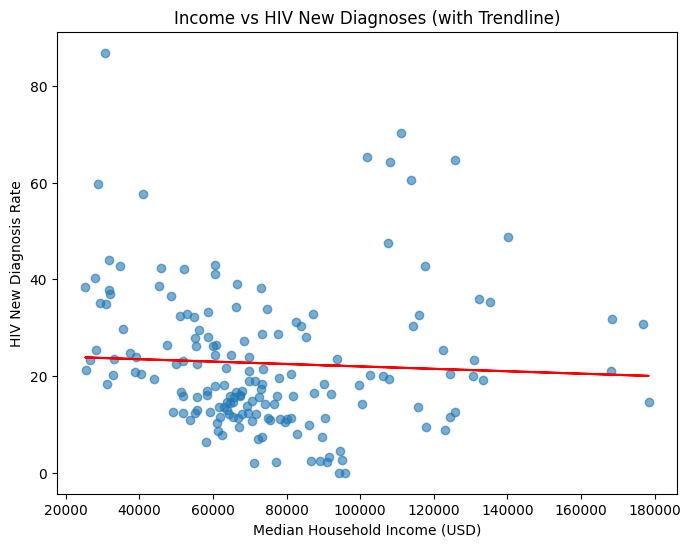

In [15]:
import numpy as np

x = merged["avg_median_income"]
y = merged["hiv_rate"]

# fit line
m, b = np.polyfit(x, y, 1)

plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.6)
plt.plot(x, m*x + b, color="red")

plt.xlabel("Median Household Income (USD)")
plt.ylabel("HIV New Diagnosis Rate")
plt.title("Income vs HIV New Diagnoses (with Trendline)")

plt.show()


## 📝 **Takeaway**

The scatter plot shows that median household income and HIV new diagnosis rates across NYC UHF neighborhoods exhibit a **weak negative relationship**. While higher-income neighborhoods tend to have slightly lower HIV diagnosis rates on average, the overall pattern is **highly dispersed**, with substantial variation at similar income levels.

This suggests that income alone does not explain geographic differences in HIV incidence. Instead, **persistent structural and place-based factors**—such as historical disparities, access to care, and demographic composition—likely play a much larger role in shaping neighborhood-level HIV outcomes.
